# On The Free Energy Penalty of Cavity Formation In Salt Solutions: Rethinking the Terms “Kosmotropic” and “Chaotropic”.

Stefan Hervø-Hansen<sup>a,*</sup> and Nobuyuki Matubayasi<sup>a,*</sup>.<br><br>
<sup>a</sup> Division of Chemical Engineering, Graduate School of Engineering Science, Osaka University, Toyonaka, Osaka 560-8531, Japan.<br>
<sup>*</sup> To whom correspondence may be addressed: stefan@cheng.es.osaka-u.ac.jp and nobuyuki@cheng.es.osaka-u.ac.jp.

## Analysis & Model Construction


## Import of Python Modules & Auxiliary Functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os,time
import mdtraj as md
import parmed as pmd

from math import isclose

In [ ]:
salts = {
    'NaF': {'cation': 'Na', 'anion': 'F', 'rcation': 'NA', 'ranion': 'F'},
    'NaCl': {'cation': 'Na', 'anion': 'Cl', 'rcation': 'NA', 'ranion': 'CL'},
    'NaI': {'cation': 'Na', 'anion': 'I', 'rcation': 'NA', 'ranion': 'I'},
    # 'KF': {'cation': 'K', 'anion': 'F', 'rcation': 'K', 'ranion': 'F'},
    # 'KCl': {'cation': 'K', 'anion': 'Cl', 'rcation': 'K', 'ranion': 'CL'},
    # 'KI': {'cation': 'K', 'anion': 'I', 'rcation': 'K', 'ranion': 'I'},
    # 'RbF': {'cation': 'Rb', 'anion': 'F', 'rcation': 'RB', 'ranion': 'F'},
    # 'Rbl': {'cation': 'Rb', 'anion': 'Cl', 'rcation': 'RB', 'ranion': 'CL'},
    # 'RbI': {'cation': 'Rb', 'anion': 'I', 'rcation': 'RB', 'ranion': 'I'},
}

solutes = {
    'ethane': {'resname': 'ETH'},
    'n-butane': {'resname': 'BUT'},
    'n-hexane': {'resname': 'HEX'},
}

concentrations = {
#     0.0:{'N_solute':1,'N_water':10000,'N_cation':0,'N_anion':0},
    # 0.25:{'N_solute':1,'N_water':10000,'N_cation':45,'N_anion':45},
    0.5:{'N_solute':1,'N_water':10000,'N_cation':90,'N_anion':90},
#     0.75:{'N_solute':1,'N_water':10000,'N_cation':135,'N_anion':135},
    # 1.00:{'N_solute':1,'N_water':10000,'N_cation':180,'N_anion':180}
}


rdf_pairs = {
    # 'solute_water':{'index1': '2','index2': '9','resname1': L['resname'],'resname2': 'HOH'},
    # 'solute_cation':{'index1': '2','index2': '3','resname1': L['resname'],'resname2': S['cation']},  
    # 'solute_anion':{'index1': '2','index2': '4','resname1': L['resname'],'resname2': S['anion']},
    # 'water_cation':{'index1': '9','index2': '3','resname1': 'HOH','resname2': S['cation']}, 
    # 'water_anion':{'index1': '9','index2': '4','resname1': 'HOH','resname2': S['anion']},
    'water_water':{'index1': '9','index2': '9','resname1': 'HOH','resname2': 'HOH'},    
}

### Calc RDF

In [ ]:
script = """#!/bin/bash
#PBS -l nodes=oz01:ppn=1

if [ "$PBS_O_WORKDIR" != "" ];then
  cd $PBS_O_WORKDIR
fi
NUMNODES=`wc -l < $PBS_NODEFILE`

source /data2/APPLI/packages/gromacs/gromacs-2021.4-intel-single.rc

cd /home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/rdf

gmx_mpi rdf -f /home/lin/Cavity-Formation/md/solute_salt_water/{solute}/{salt}/{concentration}/md/solution_run.xtc -s /home/lin/Cavity-Formation/md/solute_salt_water/{solute}/{salt}/{concentration}/md/solution_run.tpr -n /home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/rdf/index.ndx -cn cn_{resname1}_{resname2}.xvg -o rdf_{resname1}_{resname2}.xvg << EOF
{index1}
{index2}
EOF
"""

In [ ]:
tag = 0
for solute,L in solutes.items():
    for salt,S in salts.items():
        for concentration,N in concentrations.items():
            output_dir = f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/rdf/script'
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            os.chdir(f'{output_dir}')
            for rdf_pair,R in rdf_pairs.items():
                print (script.format(solute=solute,salt=salt,concentration=concentration,resname1=R['resname1'],resname2=R['resname2'],index1=R['index1'],index2=R['index2']))
                with open(f'run{tag:02}.sh', 'w') as f:
                    f.write(script.format(solute=solute,salt=salt,concentration=concentration,resname1=R['resname1'],resname2=R['resname2'],index1=R['index1'],index2=R['index2']))
                f.close()
                os.system(f'qsub run{tag:02}.sh')
                tag = tag+1


#### plot data

In [ ]:
# treat lines start with '#' and '@' as comment in xvg files made by GROMACS
def extract_data():
    for line in xvg:
        if line[0] == '#' or line[0] == '@':
            continue
        else:
            cols = line.split()
            x.append(float(cols[0]))
            y.append(float(cols[1])) 
    
    

In [ ]:
from matplotlib import cm
fig, axes = plt.subplots(3,2,figsize=(8*row,4*col))
fig.subplots_adjust(wspace=0.4, hspace=0.6)
# axes2 = axes[0].twinx()





# /home/lin/Cavity-Formation/md/solute_salt_water/n-butane/NaF/0.5/md
for solute,L in solutes.items():
    for salt,S in salts.items():
        for concentration,N in concentrations.items():
            rdf_pairs = {
    'solute_water':{'index1': '2','index2': '9','resname1': L['resname'],'resname2': 'HOH'},
    'solute_cation':{'index1': '2','index2': '3','resname1': L['resname'],'resname2': S['cation']},  
    'solute_anion':{'index1': '2','index2': '4','resname1': L['resname'],'resname2': S['anion']},
    'water_cation':{'index1': '9','index2': '3','resname1': 'HOH','resname2': S['cation']}, 
    'water_anion':{'index1': '9','index2': '4','resname1': 'HOH','resname2': S['anion']},
    'water_water':{'index1': '9','index2': '9','resname1': 'HOH','resname2': 'HOH'},    
}
            for rdf_pair,R in rdf_pairs.items():
                if rdf_pair == 'solute_water':
                    x, y = [], []
                    resname1 = R['resname1']
                    resname2 = R['resname2']
                    print (resname1)
                    print (resname2)
                    with open(f"/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/rdf/rdf_{resname1}_{resname2}.xvg") as xvg:
                        extract_data()
                    axes[0][0].plot(x,y,label=S['anion']+'⁻', linewidth=1) 
                    axes[0][0].set_title(rdf_pair)
                    # x, y = [], []
                    # with open(f"/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/rdf/cn_{resname1}_{resname2}.xvg") as xvg:
                    #     extract_data()
                    # axes2 = axes[0][0].twinx()
                    # axes2.set_ylim(0,100)
                    # axes2.plot(x,y,label=S['anion']+'⁻', linewidth=1) 

                if rdf_pair == 'solute_cation':
                    x, y = [], []
                    resname1 = R['resname1']
                    resname2 = R['resname2']
                    print (resname1)
                    print (resname2)
                    with open(f"/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/rdf/rdf_{resname1}_{resname2}.xvg") as xvg:
                        extract_data()
                    axes[0][1].plot(x,y,label=S['anion']+'⁻', linewidth=1)                
                    axes[0][1].set_title(rdf_pair)

                if rdf_pair == 'solute_anion':
                    x, y = [], []
                    # print (salt)
                    resname1 = R['resname1']
                    resname2 = R['resname2']
                    print (resname1)
                    print (resname2)
                    with open(f"/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/rdf/rdf_{resname1}_{resname2}.xvg") as xvg:
                        extract_data()
                    axes[1][0].plot(x,y,label=S['anion']+'⁻', linewidth=1)
                    axes[1][0].set_title(rdf_pair)
                
                if rdf_pair == 'water_cation':
                    x, y = [], []
                    resname1 = R['resname1']
                    resname2 = R['resname2']
                    print (resname1)
                    print (resname2)
                    with open(f"/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/rdf/rdf_{resname1}_{resname2}.xvg") as xvg:
                        extract_data()
                    axes[1][1].plot(x,y,label=S['anion']+'⁻', linewidth=1)                
                    axes[1][1].set_title(rdf_pair)

                if rdf_pair == 'water_anion':
                    x, y = [], []
                    # print (salt)
                    resname1 = R['resname1']
                    resname2 = R['resname2']
                    print (resname1)
                    print (resname2)
                    with open(f"/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/rdf/rdf_{resname1}_{resname2}.xvg") as xvg:
                        extract_data()
                    axes[2][0].plot(x,y,label=S['anion']+'⁻', linewidth=1)
                    axes[2][0].set_title(rdf_pair)

                if rdf_pair == 'water_water':
                    x, y = [], []
                    # print (salt)
                    resname1 = R['resname1']
                    resname2 = R['resname2']
                    print (resname1)
                    print (resname2)
                    with open(f"/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/rdf/rdf_{resname1}_{resname2}.xvg") as xvg:
                        extract_data()
                    axes[2][0].plot(x,y,label='Water', linewidth=1, linestyle='dashed')
                    axes[2][0].set_title(rdf_pair)
        
        # plot HOH vs anion RDF


for i,ax in enumerate(axes.flat):
    ax.set_xlim(0,1.0)
    ax.legend()

# fig.savefig('/home/lin/data/test/test_RDF_output.eps')



# axes[0].legend(frameon=False)
# # axes[0].set_xlim(0,0.7)
# # axes[0].set_ylim(0,4.5)
# axes[0].set_xlabel(r'Distance,$r_{\mathrm{H_2O - Cation}}$[nm]',fontsize=20)
# axes[0].set_ylabel('RDF',fontsize=20)

# axes2[0].legend(frameon=False)
# axes2.set_xlim(0,0.7)
# axes2.set_ylim(0,0.1)
# axes2.set_ylabel('Cumulative RDFs',fontsize=20)

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(13,10))
mddir = '/data4/lin/Cavity-Formation/md'

i = True
for salt,S in salts.items():
    for concentration,N in concentrations.items():
        output_dir = f'/home/lin/Cavity-Formation/Simulations/salt_water/{salt}/{concentration}'
        md_dir = f'/home/lin/Cavity-Formation/md/salt_water/{salt}/{concentration}/md'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)


        os.chdir(f'{md_dir}')
        traj = md.load_xtc(f'solution_run.xtc',top=f'solution_run.gro')

        # for water-cation
        pairs = traj.topology.select_pairs(selection1="resname NA",selection2="resname HOH")
        rdf = md.compute_rdf(traj,pairs,r_range=(0.0, 0.7))
        print('finshed conpute rdf')
        # with open('rdf_output','w') as rdf_output:
        #     rdf_output.write(str(rdf))
        axes[0].legend(frameon=False)
        axes[0].plot(rdf[0],rdf[1],linewidth=2,label=S['anion'])
        # i = False

        # for water-anion
        pairs = traj.topology.select_pairs(selection1="resname {}".format(S['anion']),selection2="resname HOH")
        rdf = md.compute_rdf(traj,pairs,r_range=(0.0, 0.7))
        print('finshed conpute rdf')
        # with open('rdf_output','w') as rdf_output:
        #     rdf_output.write(str(rdf))
        axes[1].legend(frameon=False)
        axes[1].plot(rdf[0],rdf[1],linewidth=2,label=S['anion'])

fig.savefig('/home/lin/data/test/RDF_output2.eps')
            
        

            


### ERmod

In [ ]:
homedir = '/home/lin'
mddir = '/home/lin/Cavity-Formation/md'
outputdir = '/home/lin/Cavity-Formation/Simulations/solute_salt_water'

salts = {
    'NaF': {'cation': 'Na', 'anion': 'F', 'rcation': 'NA', 'ranion': 'F'},
    'NaCl': {'cation': 'Na', 'anion': 'Cl', 'rcation': 'NA', 'ranion': 'CL'},
    'NaI': {'cation': 'Na', 'anion': 'I', 'rcation': 'NA', 'ranion': 'I'}
}

solutes = {
    # 'ethane': {'resname': 'ETH'},
    'n-butane': {'resname': 'BUT'},
    # 'propane': {'resname': 'PRP'},
    # 'n-hexane': {'resname': 'HEX'},
}

concentrations = {
#     0.0:{'N_solute':1,'N_water':10000,'N_cation':0,'N_anion':0},
    # 0.25:{'N_solute':1,'N_water':10000,'N_cation':45,'N_anion':45},
    0.5:{'N_solute':1,'N_water':10000,'N_cation':90,'N_anion':90},
#     0.75:{'N_solute':1,'N_water':10000,'N_cation':135,'N_anion':135},
    # 1.00:{'N_solute':1,'N_water':10000,'N_cation':180,'N_anion':180}
}



In [ ]:
for solute,L in solutes.items():
    for salt,S in salts.items():
        for concentration,C in concentrations.items():
            output_dir = f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}'
            if not os.path.exists(f'{output_dir}/fe'):
                dirs = ['fe','el','lj']
                for dir in dirs:    
                    os.makedirs(f'{output_dir}/{dir}')

In [ ]:
ETH_Slt_lj = """1 C -0.09435 0.45538912 0.00000000
2 C -0.09435 0.45538912 0.00000000
3 H 0.03145 0.066021356 0.00000000
4 H 0.03145 0.066021356 0.00000000
5 H 0.03145 0.066021356 0.00000000
6 H 0.03145 0.066021356 0.00000000
7 H 0.03145 0.066021356 0.00000000
8 H 0.03145 0.066021356 0.00000000"""

ETH_Slt_el = """1 C -0.09435 0.00000000 0.33795318
2 C -0.09435 0.00000000 0.33795318
3 H 0.03145 0.000000000 0.26445434
4 H 0.03145 0.000000000 0.26445434
5 H 0.03145 0.000000000 0.26445434
6 H 0.03145 0.000000000 0.26445434
7 H 0.03145 0.000000000 0.26445434
8 H 0.03145 0.000000000 0.26445434"""

BUT_Slt_lj = """1 C -0.09238586 0.45538912 0.00000000
2 C -0.08068586 0.45538912 0.00000000
3 C -0.08068586 0.45538912 0.00000000
4 C -0.09238586 0.45538912 0.00000000
5 H 0.03208114 0.066021356 0.00000000
6 H 0.03208114 0.066021356 0.00000000
7 H 0.03208114 0.066021356 0.00000000
8 H 0.03841414 0.066021356 0.00000000
9 H 0.03841414 0.066021356 0.00000000
10 H 0.03841414 0.066021356 0.00000000
11 H 0.03841414 0.066021356 0.00000000
12 H 0.03208114 0.066021356 0.00000000
13 H 0.03208114 0.066021356 0.00000000
14 H 0.03208114 0.066021356 0.00000000"""

BUT_Slt_el = """1 C -0.09238586 0.00000000 0.33795318
2 C -0.08068586 0.00000000 0.33795318
3 C -0.08068586 0.00000000 0.33795318
4 C -0.09238586 0.00000000 0.33795318
5 H 0.03208114 0.000000000 0.26445434
6 H 0.03208114 0.000000000 0.26445434
7 H 0.03208114 0.000000000 0.26445434
8 H 0.03841414 0.000000000 0.26445434
9 H 0.03841414 0.000000000 0.26445434
10 H 0.03841414 0.000000000 0.26445434
11 H 0.03841414 0.000000000 0.26445434
12 H 0.03208114 0.000000000 0.26445434
13 H 0.03208114 0.000000000 0.26445434
14 H 0.03208114 0.000000000 0.26445434"""

HEX_Slt_lj = """1 C -0.0922 0.45538912 0.00000000
2 C -0.0805 0.45538912 0.00000000
3 C -0.0795 0.45538912 0.00000000
4 C -0.0795 0.45538912 0.00000000
5 C -0.0805 0.45538912 0.00000000
6 C -0.0922 0.45538912 0.00000000
7 H 0.0326 0.066021356 0.00000000
8 H 0.0326 0.066021356 0.00000000
9 H 0.0326 0.066021356 0.00000000
10 H 0.0386 0.066021356 0.00000000
11 H 0.0386 0.066021356 0.00000000
12 H 0.0386 0.066021356 0.00000000
13 H 0.0386 0.066021356 0.00000000
14 H 0.0386 0.066021356 0.00000000
15 H 0.0386 0.066021356 0.00000000
16 H 0.0386 0.066021356 0.00000000
17 H 0.0386 0.066021356 0.00000000
18 H 0.0326 0.066021356 0.00000000
19 H 0.0326 0.066021356 0.00000000
20 H 0.0326 0.066021356 0.00000000"""

HEX_Slt_el = """1 C -0.0922 0.00000000 0.33795318
2 C -0.0805 0.00000000 0.33795318
3 C -0.0795 0.00000000 0.33795318
4 C -0.0795 0.00000000 0.33795318
5 C -0.0805 0.00000000 0.33795318
6 C -0.0922 0.00000000 0.33795318
7 H 0.0326 0.000000000 0.26445434
8 H 0.0326 0.000000000 0.26445434
9 H 0.0326 0.000000000 0.26445434
10 H 0.0386 0.000000000 0.26445434
11 H 0.0386 0.000000000 0.26445434
12 H 0.0386 0.000000000 0.26445434
13 H 0.0386 0.000000000 0.26445434
14 H 0.0386 0.000000000 0.26445434
15 H 0.0386 0.000000000 0.26445434
16 H 0.0386 0.000000000 0.26445434
17 H 0.0386 0.000000000 0.26445434
18 H 0.0326 0.000000000 0.26445434
19 H 0.0326 0.000000000 0.26445434
20 H 0.0326 0.000000000 0.26445434"""



In [ ]:
header = """#!/bin/bash
#PBS -l nodes=1:nu-g:ppn=36

if [ "$PBS_O_WORKDIR" != "" ];then
  cd $PBS_O_WORKDIR
fi
NUMNODES=`wc -l < $PBS_NODEFILE`

# source /data2/APPLI/packages/ermod-0.3.7/ermod-intel.rc GROMACS
"""

add_script = """
##################calc fe##################

cd /home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/fe

gen_structure -t {top_dir}/topol.top -s {resname}

cd soln

gen_input -x {solution_traj} -l {solution_log}
mpirun -machinefile $PBS_NODEFILE -np $NUMNODES ermod

cd ..

cd refs

gen_input -x {refs_traj} -l {refs_log} -s {solute_traj}
mpirun -machinefile $PBS_NODEFILE -np $NUMNODES ermod

cd ..

cat << EOF > parameters_fe
&fevars
inptemp=300.000000
cumuint = 'yes'
/
EOF

mpirun -machinefile $PBS_NODEFILE -np $NUMNODES slvfe > free_energy.txt
excl2.exe soln/uvrange.tt cumsfe excl.out

DATE=`date`
echo -e '\n'$DATE'\nendcalc\nworking dir is /home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/fe' >> /home/lin/Cavity-Formation/Reserch_notes.txt

##################calc fe##################

##################calc lj##################

cd /home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/lj

gen_structure -t {top_dir}/topol.top -s {resname}

cd soln

gen_input -x {solution_traj} -l {solution_log}
cat << EOF > SltInfo
{Slt_lj}
EOF
mpirun -machinefile $PBS_NODEFILE -np $NUMNODES ermod

DATE=`date`
echo -e '\n'$DATE'\nendcalc\nworking dir is /home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/lj' >> /home/lin/Cavity-Formation/Reserch_notes.txt

##################calc lj##################

##################calc el##################

cd /home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/el

gen_structure -t {top_dir}/topol.top -s {resname}

cd soln

gen_input -x {solution_traj} -l {solution_log}
cat << EOF > SltInfo
{Slt_el}
EOF
mpirun -machinefile $PBS_NODEFILE -np $NUMNODES ermod

DATE=`date`
echo -e '\n'$DATE'\nendcalc\nworking dir is /home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/el' >> /home/lin/Cavity-Formation/Reserch_notes.txt

##################calc el##################

"""

In [ ]:
tag = 0
for solute,L in solutes.items():
    Slt_el_command = 'Slt_el = ' + L['resname'] + '_Slt_el'
    exec(Slt_el_command)
    Slt_lj_command = 'Slt_lj = ' + L['resname'] + '_Slt_lj'
    exec(Slt_lj_command)
    # top_dir = f'{mddir}/solute_water/{solute}/solution/sys'
    # solution_dir = f'{mddir}/solute_water/{solute}/solution/md'
    # refs_dir = f'{mddir}/pure_water/10_md'
    # solute_dir = f'{mddir}/solute_water/{solute}/solute/md/solute_run.xtc'

    # solution_traj = f'{solution_dir}/solution_run.xtc'
    # solution_log = f'{solution_dir}/solution_run.log'
    # refs_traj = f'{refs_dir}/solution_run.xtc'
    # refs_log = f'{refs_dir}/solution_run.log'
    # solute_traj = f'{solute_dir}/solute_run.xtc'

    # output_dir = '/data4/lin/Cavity-Formation/Simulations'

    # %cd {output_dir}/nosalt
    # with open('ermod.sh', 'w') as f:
    #     f.write(ermod_script.format(top_dir=top_dir,solution_traj=solution_traj,solution_log=solution_log,refs_traj=refs_traj,refs_log=refs_log,solute_traj=solute_dir,resname=L['resname']))
    # f.close()
    # !qsub ermod.sh

    for salt,S in salts.items():
        for concentration,N in concentrations.items():
            new_dir_path = f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}'
            if not os.path.exists(new_dir_path):
                cases = ['fe','el','lj']
                for case in cases:
                    os.makedirs(f'{new_dir_path}/{case}')

            top_dir = f'{mddir}/solute_salt_water/{solute}/{salt}/{concentration}/sys'
            solution_dir = f'{mddir}/solute_salt_water/{solute}/{salt}/{concentration}/md'
            refs_dir = f'{mddir}/salt_water/{salt}/{concentration}/md'
            solute_dir = f'{mddir}/solute_water/{solute}/solute/md'

            solution_traj = f'{solution_dir}/solution_run.xtc'
            solution_log = f'{solution_dir}/solution_run.log'
            refs_traj = f'{refs_dir}/solution_run.xtc'
            refs_log = f'{refs_dir}/solution_run.log'
            solute_traj = f'{solute_dir}/solute_run.xtc'
            
            add = add_script.format(top_dir=top_dir,solution_traj=solution_traj,solution_log=solution_log,refs_traj=refs_traj,refs_log=refs_log,solute_traj=solute_traj,resname=L['resname'],solute=solute,salt=salt,concentration=concentration,Slt_lj=Slt_lj,Slt_el=Slt_el)
            if tag == 0:
                script = header + add
            else:
                script = script + add
            print ('tag =')
            print (tag)
            tag = tag + 1
            
print (script)

os.chdir('/home/lin/Cavity-Formation/Simulations/solute_salt_water')
with open('run.sh', 'w') as f:
    f.write(script)
f.close()
os.system('qsub run.sh')
            

### Analysis of fe

In [ ]:
salts = {
    'NaF': {'cation': 'NA', 'anion': 'F'},
    'NaCl': {'cation': 'NA', 'anion': 'CL'},
    'NaI': {'cation': 'NA', 'anion': 'I'}
}

solutes = {
    'ethane': {'resname': 'ETH'},
    'n-butane': {'resname': 'BUT'},
    # 'propane': {'resname': 'PRP'},
    'n-hexane': {'resname': 'HEX'},
}

concentrations = {
#     0.0:{'N_solute':1,'N_water':10000,'N_cation':0,'N_anion':0},
    # 0.25:{'N_solute':1,'N_water':10000,'N_cation':45,'N_anion':45},
    0.5:{'N_solute':1,'N_water':10000,'N_cation':90,'N_anion':90},
#     0.75:{'N_solute':1,'N_water':10000,'N_cation':135,'N_anion':135},
    # 1.00:{'N_solute':1,'N_water':10000,'N_cation':180,'N_anion':180}
}



#### Pair energy (subtructed solute in pure water pair energy)

-6.35653
-6.35653
-6.35653
-10.7887
-10.7887
-10.7887
-14.9928
-14.9928


No handles with labels found to put in legend.


-14.9928
[  0.2471   -0.79683 -14.75041]


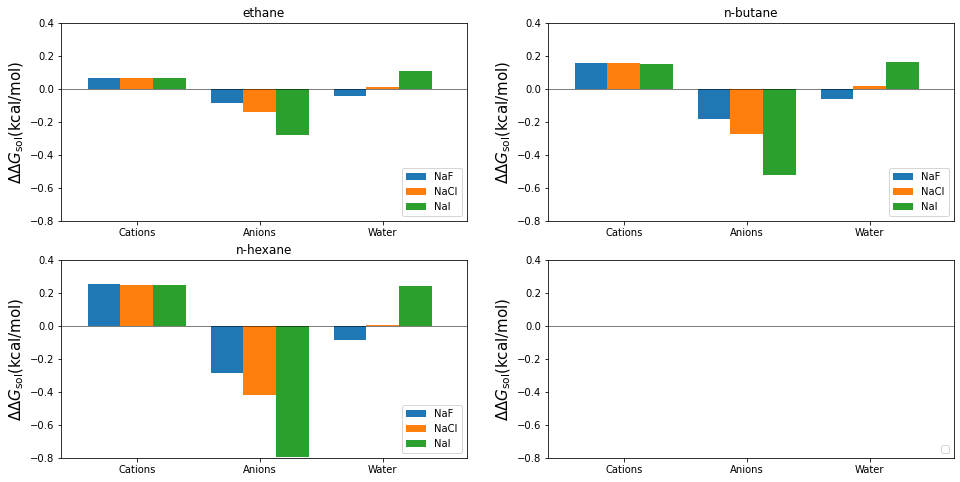

In [14]:
row = 2
col = 2

fig, axes = plt.subplots(row,col,figsize=(8*row,4*col))

tag2 = 0
for solute,L in solutes.items():
    tag = 1
    for salt,S in salts.items():
        for concentration,C in concentrations.items():
            with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/nosalt/soln/weight_soln') as f:
                nosalt_weights = list(np.float_([line.split()[1] for line in f]))

            with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/nosalt/soln/aveuv.tt') as f:
                nosalt_avs = list(np.float_([line.split() for line in f]))
            tot_weights = 0
            tot_nosalt_wat_av = 0
            weighted_avs = []
            tag1 = 0
            for i in nosalt_weights:
                tot_weights = tot_weights + float(i)
                weighted_avs.append(i*nosalt_avs[tag1])
                tot_nosalt_wat_av = tot_nosalt_wat_av + weighted_avs[tag1][1]
                tag1 = tag1 + 1

            nosalt_wat_av = np.round(tot_nosalt_wat_av/tot_weights,5)

            print(nosalt_wat_av)
            
            with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/fe/soln/weight_soln') as f:
                weights = list(np.float_([line.split()[1] for line in f]))    

            with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/fe/soln/aveuv.tt') as f:
                avs = list(np.float_([line.split() for line in f]))

            tot_cation_av, tot_anion_av, tot_wat_av, tot_weights = 0, 0, 0, 0
            weighted_avs = []
            tag1 = 0
            for i in weights:
                tot_weights = tot_weights + float(i)
                weighted_avs.append(i*avs[tag1])
                tot_cation_av = tot_cation_av + weighted_avs[tag1][1]
                tot_anion_av = tot_anion_av + weighted_avs[tag1][2]
                tot_wat_av = tot_wat_av + weighted_avs[tag1][3]
                tag1 = tag1 + 1
            
            tot_av = np.round(np.array([tot_cation_av,tot_anion_av,tot_wat_av])/tot_weights,5)
            left = np.array(['Cations', 'Anions', 'Water'])
            x = np.array([1, 2, 3])
            height = 'height_' + str(tag) + '= [tot_av[0],tot_av[1],tot_av[2]-nosalt_wat_av]'
            exec(height)
            # yerr = 'yerr_' + str(tag) + '= np.array([totyerr,saltfe[4],saltfe[6],watyerr])'
            # exec(yerr)

            margin = 0.2
            total_width = 1 - margin
            width = (1-margin)/len(salts)
            pos = x - total_width*( 1- (2*tag+1)/len(salts) )/2

            if tag2 % 2 == 0:
                flame_col = 0
            else:
                flame_col = 1

            flame_row = tag2 // row

            plot_script = 'axes[' + str(flame_row) + '][' + str(flame_col) + '].bar(pos,height_' + str(tag) + ',align="center",width=width,label=salt)'
            title_script = 'axes[' + str(flame_row) + '][' + str(flame_col) + f'].set_title("{solute}")'
            exec(plot_script)
            exec(title_script)
        tag = tag + 1
    tag2 = tag2 + 1

labels = ['Cations', 'Anions', 'Water']
axs = plt.gcf().get_axes()
# print (axs)

for ax in axs:
    plt.axes(ax)
    plt.legend(loc=4)
    plt.xticks(x+width, labels)
    plt.hlines(0,0.65,4.95, colors='black',linewidth=0.5)
    plt.xlim(0.65,3.95)
    plt.ylim(-0.8,0.4)
    plt.ylabel('$\Delta\Delta G_{\mathrm{sol}}$(kcal/mol)',fontsize=15)

print(tot_av)

No handles with labels found to put in legend.


-6.35653
-10.7887
-14.9928
-6.35653
-10.7887
-14.9928
-6.35653
-10.7887
-14.9928
[  0.2471   -0.79683 -14.75041]


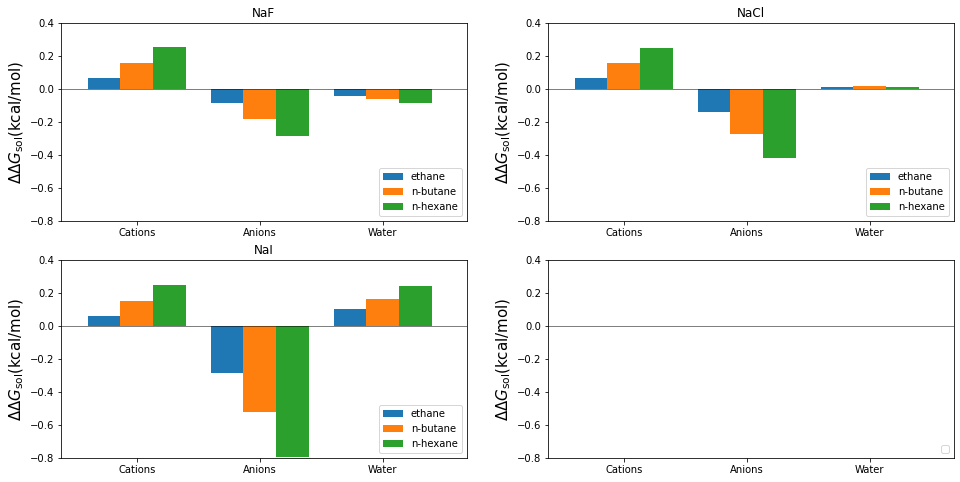

In [15]:
row = 2
col = 2

fig, axes = plt.subplots(row,col,figsize=(8*row,4*col))

tag2 = 0
for salt,S in salts.items():
    tag = 1
    for solute,L in solutes.items():
        for concentration,C in concentrations.items():
            with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/nosalt/soln/weight_soln') as f:
                nosalt_weights = list(np.float_([line.split()[1] for line in f]))

            with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/nosalt/soln/aveuv.tt') as f:
                nosalt_avs = list(np.float_([line.split() for line in f]))
            tot_weights = 0
            tot_nosalt_wat_av = 0
            weighted_avs = []
            tag1 = 0
            for i in nosalt_weights:
                tot_weights = tot_weights + float(i)
                weighted_avs.append(i*nosalt_avs[tag1])
                tot_nosalt_wat_av = tot_nosalt_wat_av + weighted_avs[tag1][1]
                tag1 = tag1 + 1

            nosalt_wat_av = np.round(tot_nosalt_wat_av/tot_weights,5)

            print(nosalt_wat_av)
            
            with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/fe/soln/weight_soln') as f:
                weights = list(np.float_([line.split()[1] for line in f]))    

            with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/fe/soln/aveuv.tt') as f:
                avs = list(np.float_([line.split() for line in f]))

            tot_cation_av, tot_anion_av, tot_wat_av, tot_weights = 0, 0, 0, 0
            weighted_avs = []
            tag1 = 0
            for i in weights:
                tot_weights = tot_weights + float(i)
                weighted_avs.append(i*avs[tag1])
                tot_cation_av = tot_cation_av + weighted_avs[tag1][1]
                tot_anion_av = tot_anion_av + weighted_avs[tag1][2]
                tot_wat_av = tot_wat_av + weighted_avs[tag1][3]
                tag1 = tag1 + 1
            
            tot_av = np.round(np.array([tot_cation_av,tot_anion_av,tot_wat_av])/tot_weights,5)
            left = np.array(['Cations', 'Anions', 'Water'])
            x = np.array([1, 2, 3])
            height = 'height_' + str(tag) + '= [tot_av[0],tot_av[1],tot_av[2]-nosalt_wat_av]'
            exec(height)
            # yerr = 'yerr_' + str(tag) + '= np.array([totyerr,saltfe[4],saltfe[6],watyerr])'
            # exec(yerr)

            margin = 0.2
            total_width = 1 - margin
            width = (1-margin)/len(salts)
            pos = x - total_width*( 1- (2*tag+1)/len(salts) )/2

            if tag2 % 2 == 0:
                flame_col = 0
            else:
                flame_col = 1

            flame_row = tag2 // row

            plot_script = 'axes[' + str(flame_row) + '][' + str(flame_col) + '].bar(pos,height_' + str(tag) + ',align="center",width=width,label=solute)'
            title_script = 'axes[' + str(flame_row) + '][' + str(flame_col) + '].set_title(salt)'
            exec(plot_script)
            exec(title_script)
        tag = tag + 1
    tag2 = tag2 + 1

labels = ['Cations', 'Anions', 'Water']
axs = plt.gcf().get_axes()
# print (axs)

for ax in axs:
    plt.axes(ax)
    plt.legend(loc=4)
    plt.xticks(x+width, labels)
    plt.hlines(0,0.65,4.95, colors='black',linewidth=0.5)
    plt.xlim(0.65,3.95)
    plt.ylim(-0.8,0.4)
    plt.ylabel('$\Delta\Delta G_{\mathrm{sol}}$(kcal/mol)',fontsize=15)

print(tot_av)

No handles with labels found to put in legend.


1.0
1.0
1.0
[<AxesSubplot:title={'center':'ethane'}>, <AxesSubplot:title={'center':'n-butane'}>, <AxesSubplot:title={'center':'n-hexane'}>, <AxesSubplot:>]
[  0.2471   -0.79683 -14.75041]


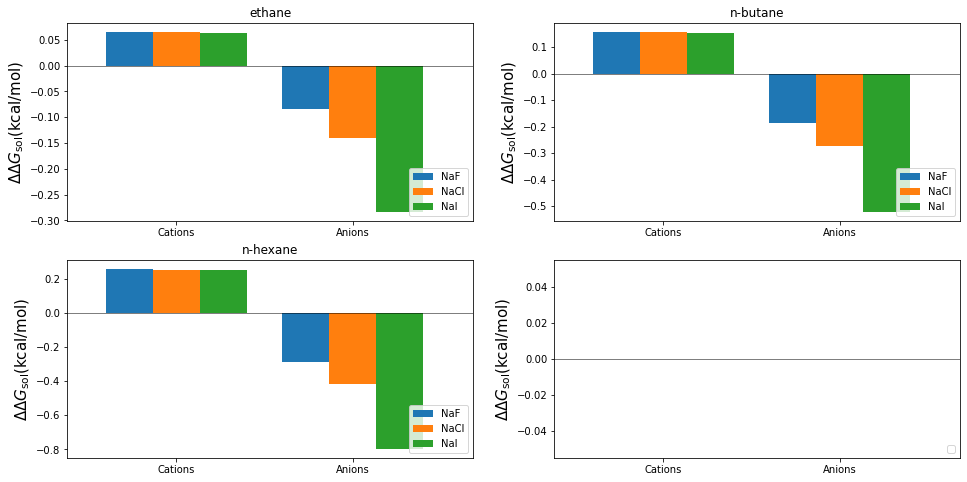

In [16]:
row = 2
col = 2

fig, axes = plt.subplots(row,col,figsize=(8*row,4*col))

tag2 = 0
for solute,L in solutes.items():
    if solute == 'n-butane':
        with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/old_nosalt/soln/weight_soln') as f:
            nosalt_weights = list(np.float_([line.split()[1] for line in f]))

        with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/old_nosalt/soln/aveuv.tt') as f:
            nosalt_avs = list(np.float_([line.split() for line in f]))
    else:
        with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/nosalt/soln/weight_soln') as f:
            nosalt_weights = list(np.float_([line.split()[1] for line in f]))

        with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/nosalt/soln/aveuv.tt') as f:
            nosalt_avs = list(np.float_([line.split() for line in f]))
    
    tot_weights = 0
    tot_nosalt_wat_av = 0
    weighted_avs = []
    tag1 = 0
    for i in nosalt_weights:
        tot_weights = tot_weights + float(i)
        weighted_avs.append(i*nosalt_avs[tag1])
        tot_nosalt_wat_av = tot_nosalt_wat_av + weighted_avs[tag1][1]

    nosalt_wat_av = np.round(tot_nosalt_wat_av/tot_nosalt_wat_av,5)

    print(nosalt_wat_av)

    tag = 1
    for salt,S in salts.items():
        for concentration,C in concentrations.items():
# solute = 'n-butane'
# salt = 'NaF'
# concentration = '0.5'

            with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/fe/soln/weight_soln') as f:
                weights = list(np.float_([line.split()[1] for line in f]))    

            with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/fe/soln/aveuv.tt') as f:
                avs = list(np.float_([line.split() for line in f]))

            tot_cation_av, tot_anion_av, tot_wat_av, tot_weights = 0, 0, 0, 0
            weighted_avs = []
            tag1 = 0
            for i in weights:
                tot_weights = tot_weights + float(i)
                weighted_avs.append(i*avs[tag1])
                tot_cation_av = tot_cation_av + weighted_avs[tag1][1]
                tot_anion_av = tot_anion_av + weighted_avs[tag1][2]
                tot_wat_av = tot_wat_av + weighted_avs[tag1][3]
                tag1 = tag1 + 1
            
            tot_av = np.round(np.array([tot_cation_av,tot_anion_av,tot_wat_av])/tot_weights,5)
            left = np.array(['Cations', 'Anions', 'Water'])
            x = np.array([1, 2])
            height = 'height_' + str(tag) + '= [tot_av[0],tot_av[1]]'
            exec(height)
            # yerr = 'yerr_' + str(tag) + '= np.array([totyerr,saltfe[4],saltfe[6],watyerr])'
            # exec(yerr)

            margin = 0.2
            total_width = 1 - margin
            width = (1-margin)/len(salts)
            pos = x - total_width*( 1- (2*tag+1)/len(salts) )/2

            if tag2 % 2 == 0:
                flame_col = 0
            else:
                flame_col = 1

            flame_row = tag2 // row

            plot_script = 'axes[' + str(flame_row) + '][' + str(flame_col) + '].bar(pos,height_' + str(tag) + ',align="center",width=width,label=salt)'
            title_script = 'axes[' + str(flame_row) + '][' + str(flame_col) + f'].set_title("{solute}")'
            exec(plot_script)
            exec(title_script)
        tag = tag + 1
    tag2 = tag2 + 1

labels = ['Cations', 'Anions']
axs = plt.gcf().get_axes()
print (axs)

for ax in axs:
    plt.axes(ax)
    plt.legend(loc=4)
    plt.xticks(x+width, labels)
    plt.hlines(0,0.65,2.95, colors='black',linewidth=0.5)
    plt.xlim(0.65,2.95)
    plt.ylabel('$\Delta\Delta G_{\mathrm{sol}}$(kcal/mol)',fontsize=15)

print(tot_av)

#### $\Delta\Delta G_{\textrm{sol}}$

##### $\Delta\Delta G_{\textrm{sol}}$ grouped by solute

0
1
2


No handles with labels found to put in legend.


[<AxesSubplot:title={'center':'ethane'}>, <AxesSubplot:title={'center':'n-butane'}>, <AxesSubplot:title={'center':'n-hexane'}>, <AxesSubplot:>]


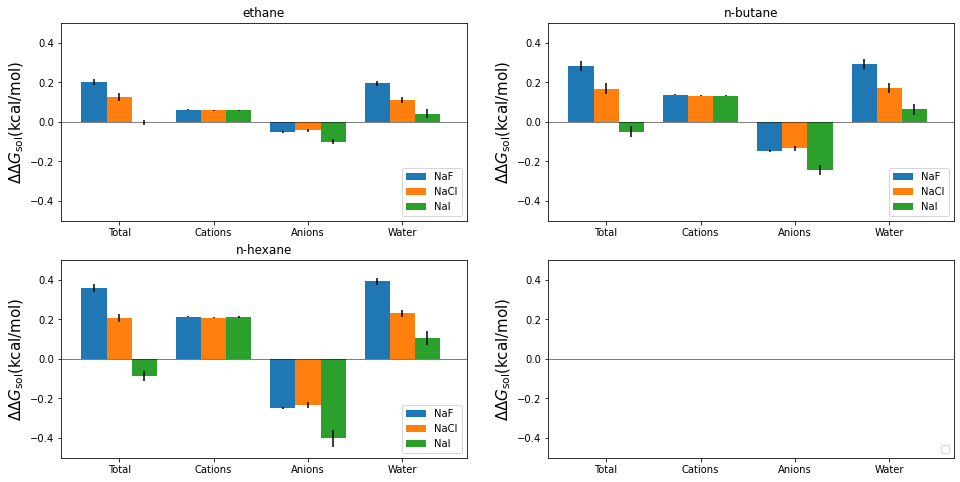

In [8]:
row = 2
col = 2

fig, axes = plt.subplots(row,col,figsize=(8*row,4*col))

tag2 = 0
for solute,L in solutes.items():
    print (tag2)
    tag = 1
    for salt,S in salts.items():
        for concentration,C in concentrations.items():
            with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/fe/free_energy.txt','r') as f:
                for line in f:
                    pass
                last_line = line.split()
            saltfe = [float(x) for x in last_line]

            if solute == 'n-butane':
                with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/old_nosalt/free_energy.txt','r') as f:
                    for line in f:
                        pass
                    last_line = line.split()                
            else:
                with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/nosalt/free_energy.txt','r') as f:
                    for line in f:
                        pass
                    last_line = line.split()
            nosaltfe = [float(x) for x in last_line]

            # print ('saltfe is')
            # print (saltfe)
            # print ('nosaltfe is')
            # print (nosaltfe)

            totfe = saltfe[1] - nosaltfe[1]
            totyerr = saltfe[2] + nosaltfe[2]
            watfe = saltfe[7] - nosaltfe[1]
            watyerr = saltfe[8] + nosaltfe[2]

            left = np.array(['Total', 'Cations', 'Anions', 'Water'])
            x = np.array([1, 2, 3, 4])
            height = 'height_' + str(tag) + '= np.array([totfe,saltfe[3],saltfe[5],watfe])'
            exec(height)
            yerr = 'yerr_' + str(tag) + '= np.array([totyerr,saltfe[4],saltfe[6],watyerr])'
            exec(yerr)

            margin = 0.2
            total_width = 1 - margin
            width = (1-margin)/len(salts)
            pos = x - total_width*( 1- (2*tag+1)/len(salts) )/2

            if tag2 % 2 == 0:
                flame_col = 0
            else:
                flame_col = 1

            flame_row = tag2 // row

            plot_script = 'axes[' + str(flame_row) + '][' + str(flame_col) + '].bar(pos,height_' + str(tag) + ',yerr=yerr_' + str(tag) + f',align="center",width={width},label=salt)'
            title_script = 'axes[' + str(flame_row) + '][' + str(flame_col) + f'].set_title("{solute}")'
            exec(plot_script)
            exec(title_script)
        tag = tag + 1
    tag2 = tag2 + 1


labels = ['Total', 'Cations', 'Anions', 'Water']
axs = plt.gcf().get_axes()
print (axs)

for ax in axs:
    plt.axes(ax)
    plt.legend(loc=4)
    plt.xticks(x+width, labels)
    plt.hlines(0,0.65,4.95, colors='black',linewidth=0.5)
    plt.xlim(0.65,4.95)
    plt.ylim(-0.5,0.5)
    plt.ylabel('$\Delta\Delta G_{\mathrm{sol}}$(kcal/mol)',fontsize=15)

##### $\Delta\Delta G_{\textrm{sol}}$ grouped by salts

No handles with labels found to put in legend.


0
1
2


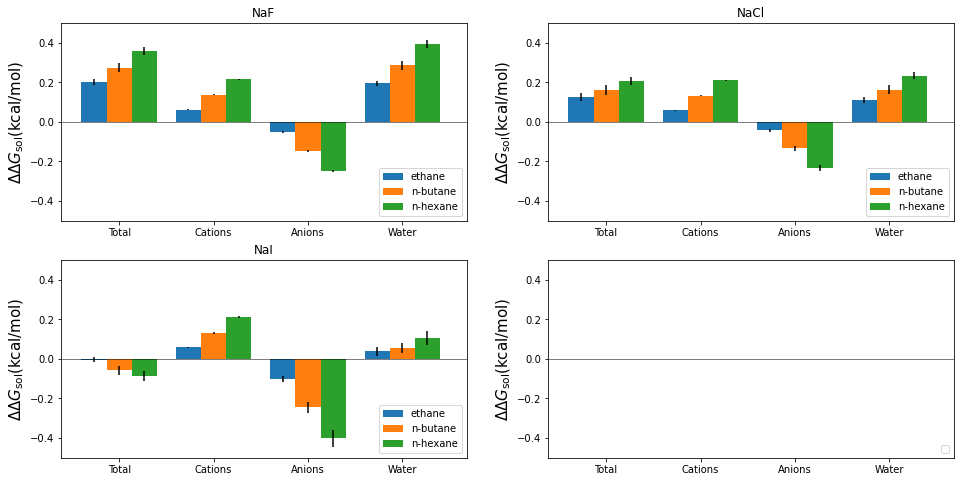

In [9]:
row = 2
col = 2

fig, axes = plt.subplots(row,col,figsize=(8*row,4*col))

tag2 = 0
for salt,S in salts.items():
    print (tag2)
    tag = 1
    for solute,L in solutes.items():
        for concentration,C in concentrations.items():
            with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/fe/free_energy.txt','r') as f:
                for line in f:
                    pass
                last_line = line.split()
            saltfe = [float(x) for x in last_line]

            with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/nosalt/free_energy.txt','r') as f:
                for line in f:
                    pass
                last_line = line.split()
            nosaltfe = [float(x) for x in last_line]

            totfe = saltfe[1] - nosaltfe[1]
            totyerr = saltfe[2] + nosaltfe[2]
            watfe = saltfe[7] - nosaltfe[1]
            watyerr = saltfe[8] + nosaltfe[2]

            left = np.array(['Total', 'Cations', 'Anions', 'Water'])
            x = np.array([1, 2, 3, 4])
            height = 'height_' + str(tag) + '= np.array([totfe,saltfe[3],saltfe[5],watfe])'
            exec(height)
            yerr = 'yerr_' + str(tag) + '= np.array([totyerr,saltfe[4],saltfe[6],watyerr])'
            exec(yerr)

            margin = 0.2
            total_width = 1 - margin
            width = (1-margin)/len(salts)
            pos = x - total_width*( 1- (2*tag+1)/len(salts) )/2

            if tag2 % 2 == 0:
                flame_col = 0
            else:
                flame_col = 1

            flame_row = tag2 // row

            plot_script = 'axes[' + str(flame_row) + '][' + str(flame_col) + '].bar(pos,height_' + str(tag) + ',yerr=yerr_' + str(tag) + f',align="center",width={width},label=solute)'
            title_script = 'axes[' + str(flame_row) + '][' + str(flame_col) + '].set_title(salt)'
            exec(plot_script)
            exec(title_script)
        tag = tag + 1
    tag2 = tag2 + 1


labels = ['Total', 'Cations', 'Anions', 'Water']
axs = plt.gcf().get_axes()

for ax in axs:
    plt.axes(ax)
    plt.legend(loc=4)
    plt.xticks(x+width, labels)
    plt.hlines(0,0.65,4.95, colors='black',linewidth=0.5)
    plt.xlim(0.65,4.95)
    plt.ylim(-0.5,0.5)
    plt.ylabel('$\Delta\Delta G_{\mathrm{sol}}$(kcal/mol)',fontsize=15)

### $\Delta \mu_{\textrm{excl}}$

No handles with labels found to put in legend.


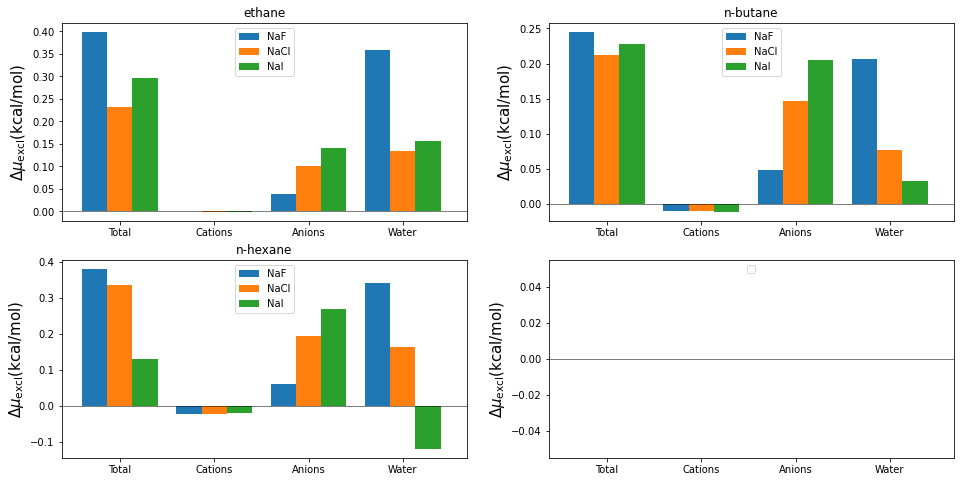

In [10]:
row = 2
col = 2

fig, axes = plt.subplots(row,col,figsize=(8*row,4*col))

tag2 = 0
for solute,L in solutes.items():
    tag = 1
    for salt,S in salts.items():
        for concentration,C in concentrations.items():
            with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/fe/excl.out','r') as f:
                for line in f:
                    pass
                last_line = line.split()
            excl = [float(x) for x in last_line]

            with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/nosalt/excl.out', 'r') as f:
                for line in f:
                    pass
                last_line = line.split()
            nosalt_excl = [float(x) for x in last_line]

            tot_mu = excl[0] - nosalt_excl[0]
            wat_mu = excl[3] - nosalt_excl[1]

            left = np.array(['Total', 'Cations', 'Anions', 'Water'])
            x = np.array([1, 2, 3, 4])
            height = 'height_' + str(tag) + '= np.array([tot_mu,excl[1],excl[2],wat_mu])'
            exec(height)
            # yerr = 'yerr_' + str(tag) + '= np.array([totyerr,saltfe[4],saltfe[6],watyerr])'
            # exec(yerr)

            margin = 0.2
            total_width = 1 - margin
            width = (1-margin)/len(salts)
            pos = x - total_width*( 1- (2*tag+1)/len(salts) )/2

            if tag2 % 2 == 0:
                flame_col = 0
            else:
                flame_col = 1

            flame_row = tag2 // row

            plot_script = 'axes[' + str(flame_row) + '][' + str(flame_col) + '].bar(pos,height_' + str(tag) + f',align="center",width={width},label=salt)'
            exec(plot_script)
            title_script = 'axes[' + str(flame_row) + '][' + str(flame_col) + '].set_title(solute)'
            exec(title_script)
        tag = tag + 1
    tag2 = tag2 + 1


labels = ['Total', 'Cations', 'Anions', 'Water']
axs = plt.gcf().get_axes()

for ax in axs:
    plt.axes(ax)
    plt.legend(loc=9)
    plt.xticks(x+width, labels)
    plt.hlines(0,0.65,4.95, colors='black',linewidth=0.5)
    plt.xlim(0.65,4.95)
    plt.ylabel('$\Delta \mu_{\mathrm{excl}}$(kcal/mol)',fontsize=15)

No handles with labels found to put in legend.


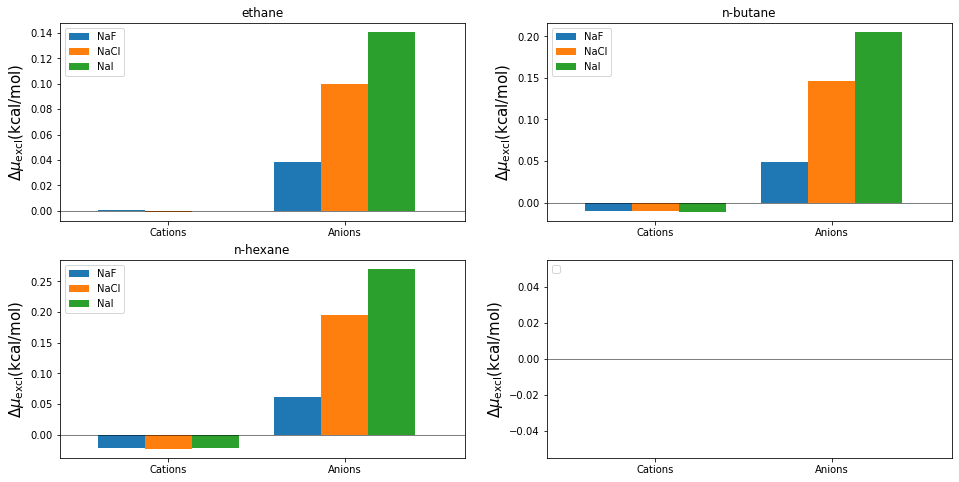

In [11]:
row = 2
col = 2

fig, axes = plt.subplots(row,col,figsize=(8*row,4*col))

tag2 = 0
for solute,L in solutes.items():
    tag = 1
    for salt,S in salts.items():
        for concentration,C in concentrations.items():
            with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/fe/excl.out','r') as f:
                for line in f:
                    pass
                last_line = line.split()
            excl = [float(x) for x in last_line]

            left = np.array(['Total', 'Cations', 'Anions', 'Water'])
            x = np.array([1, 2])
            height = 'height_' + str(tag) + '= np.array([excl[1],excl[2]])'
            exec(height)
            # yerr = 'yerr_' + str(tag) + '= np.array([totyerr,saltfe[4],saltfe[6],watyerr])'
            # exec(yerr)

            margin = 0.2
            total_width = 1 - margin
            width = (1-margin)/len(salts)
            pos = x - total_width*( 1- (2*tag+1)/len(salts) )/2

            if tag2 % 2 == 0:
                flame_col = 0
            else:
                flame_col = 1

            flame_row = tag2 // row

            plot_script = 'axes[' + str(flame_row) + '][' + str(flame_col) + '].bar(pos,height_' + str(tag) + f',align="center",width={width},label=salt)'
            exec(plot_script)
            title_script = 'axes[' + str(flame_row) + '][' + str(flame_col) + '].set_title(solute)'
            exec(title_script)
        tag = tag + 1
    tag2 = tag2 + 1


labels = ['Cations', 'Anions']
axs = plt.gcf().get_axes()

for ax in axs:
    plt.axes(ax)
    plt.legend(loc=2)
    plt.xticks(x+width, labels)
    plt.hlines(0,0.65,2.95, colors='black',linewidth=0.5)
    plt.xlim(0.65,2.95)
    plt.ylabel('$\Delta \mu_{\mathrm{excl}}$(kcal/mol)',fontsize=15)

No handles with labels found to put in legend.


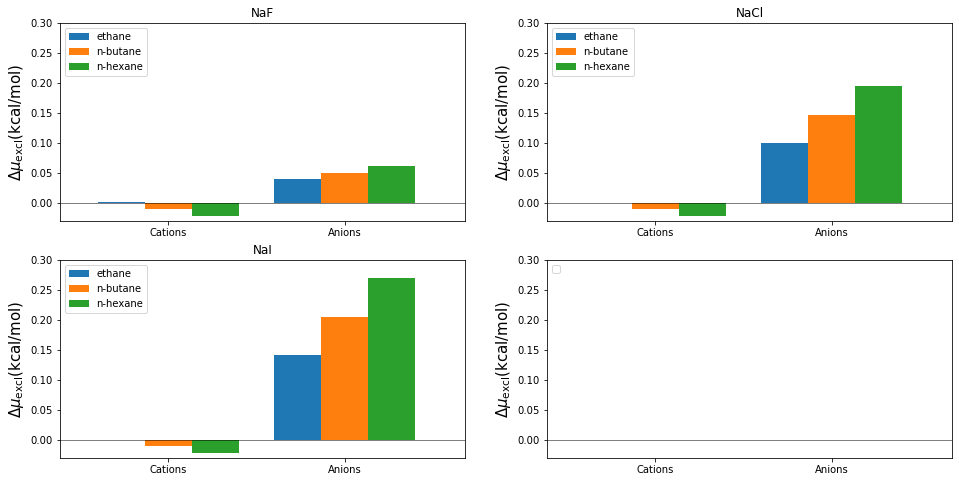

In [12]:
row = 2
col = 2

fig, axes = plt.subplots(row,col,figsize=(8*row,4*col))

tag2 = 0
for salt,S in salts.items():
    tag = 1
    for solute,L in solutes.items():
        for concentration,C in concentrations.items():
            with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/fe/excl.out','r') as f:
                for line in f:
                    pass
                last_line = line.split()
            excl = [float(x) for x in last_line]

            left = np.array(['Total', 'Cations', 'Anions', 'Water'])
            x = np.array([1, 2])
            height = 'height_' + str(tag) + '= np.array([excl[1],excl[2]])'
            exec(height)
            # yerr = 'yerr_' + str(tag) + '= np.array([totyerr,saltfe[4],saltfe[6],watyerr])'
            # exec(yerr)

            margin = 0.2
            total_width = 1 - margin
            width = (1-margin)/len(salts)
            pos = x - total_width*( 1- (2*tag+1)/len(salts) )/2

            if tag2 % 2 == 0:
                flame_col = 0
            else:
                flame_col = 1

            flame_row = tag2 // row

            plot_script = 'axes[' + str(flame_row) + '][' + str(flame_col) + '].bar(pos,height_' + str(tag) + f',align="center",width={width},label=solute)'
            exec(plot_script)
            title_script = 'axes[' + str(flame_row) + '][' + str(flame_col) + '].set_title(salt)'
            exec(title_script)
        tag = tag + 1
    tag2 = tag2 + 1


labels = ['Cations', 'Anions']
axs = plt.gcf().get_axes()

for ax in axs:
    plt.axes(ax)
    plt.legend(loc=2)
    plt.xticks(x+width, labels)
    plt.hlines(0,0.65,2.95, colors='black',linewidth=0.5)
    plt.xlim(0.65,2.95)
    plt.ylim(-0.03,0.3)
    plt.ylabel('$\Delta \mu_{\mathrm{excl}}$(kcal/mol)',fontsize=15)

pos is
[1. 2. 3.]
pos is
[1.26666667 2.26666667 3.26666667]
pos is
[1.53333333 2.53333333 3.53333333]
pos is
[1. 2. 3.]
pos is
[1.26666667 2.26666667 3.26666667]
pos is
[1.53333333 2.53333333 3.53333333]
pos is
[1. 2. 3.]
pos is
[1.26666667 2.26666667 3.26666667]
pos is
[1.53333333 2.53333333 3.53333333]


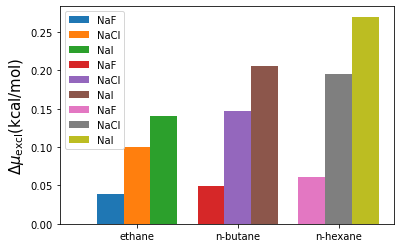

In [13]:
row = 2
col = 2

# fig, axes = plt.subplots(row,col,figsize=(8*row,4*col))
fig, axes = plt.subplots()

tag2 = 0
for solute,L in solutes.items():
    tag = 1
    for salt,S in salts.items():
        for concentration,C in concentrations.items():
            with open (f'/home/lin/Cavity-Formation/Simulations/solute_salt_water/{solute}/{salt}/{concentration}/fe/excl.out','r') as f:
                for line in f:
                    pass
                last_line = line.split()
            excl = [float(z) for z in last_line]

            x = np.array([1, 2, 3])
            height = 'height_' + str(tag) + '= np.array([excl[2]])'
            exec(height)
            # yerr = 'yerr_' + str(tag) + '= np.array([totyerr,saltfe[4],saltfe[6],watyerr])'
            # exec(yerr)

            margin = 0.2
            total_width = 1 - margin
            width = (1-margin)/len(salts)
            pos = x - total_width*( 1- (2*tag+1)/len(salts) )/2
            print ('pos is')
            print (pos)

            plot_script = 'axes.bar(pos['+ str(tag2) + '],height_' + str(tag) + ',align="center",width=width,label=salt)'
            # plot_script = 'axes.bar(pos,height_' + str(tag) + ',align="center",width=width,label=salt)'
            exec(plot_script)
            # title_script = 'axes[' + str(flame_row) + '][' + str(flame_col) + '].set_title(solute)'
            # exec(title_script)
        tag = tag + 1
    tag2 = tag2 + 1



labels = ['ethane','n-butane','n-hexane']
axs = plt.gcf().get_axes()

for ax in axs:
    plt.axes(ax)
    plt.legend(loc=2)
    plt.xticks(x+width, labels)
    plt.hlines(0,0.65,1.95, colors='black',linewidth=0.5)
    # plt.xlim(0.65,0.95)
    plt.ylabel('$\Delta \mu_{\mathrm{excl}}$(kcal/mol)',fontsize=15)

### MC_CalcVolume

In [ ]:
def MC_CalcVolume(traj, top, Niterations, molecule_box_ratio=0, blockaverages=None, debugging=False):
    """
    Computes the molecular volume by the usage of a Hit & Miss Monte Carlo algorithm.

    This function simply wraps the ``+`` operator, and does not
    do anything interesting, except for illustrating what
    the docstring of a very simple function looks like.

    Parameters
    ----------
    traj : MDTraj trajectory
        MD/MC trajectory loaded using the MD traj library.
    top : parmed topology
        topology containing the LJ parameters for all particles in the trajectory.
    molecule_box_ratio: float, default=0
        Extra lengths added to box enclosing molecule.
    blockaverages: int>1 or None, default=None
        Computation of N>1 bloc kaverages, if None this is skipped.
    debugging: bool, defualt=False
        Returning volume of molecule, volume of box, and Hit&Miss ratio. 
    
    Returns
    -------
    np.array
        The volumes of the molecules for the various frames.
        If debugging == True, the volumes are followed by the box volume and Hit&Miss ratio for the last frame.
    """
    
    # Find all radii for solute molecule
    atomic_radii = np.empty(shape=(traj.n_atoms)) # In nanometer
    for atom in top.atoms:
        atomic_radii[atom.idx] = 0.5*atom.sigma   # In Ångstrom
        atomic_radii[atom.idx] /= 10              # Convert to nanometer
        
    # Initialize data collection and block averages
    if blockaverages:
        if blockaverages < 2:
            raise Exception('blockaverages must be larger or equal to 2 or None.')
        if not isinstance(blockaverages, int):
            raise Exception('blockaverages must be an int.')
        Vdata = np.zeros(shape=(traj.n_frames, blockaverages))
    else:
        Vdata = np.zeros(shape=(traj.n_frames))
    
    
    for frameNr, frame in enumerate(traj): # Trajectory loop
        # Find min/max molecule dimensions and from there box dimensions
        molecule_dimensions = np.zeros(shape=(2,3))
        for i in range(molecule_dimensions.shape[0]):
            for j in range(molecule_dimensions.shape[1]):
                if i == 0:
                    molecule_dimensions[i][j] = np.min(frame.xyz[0][:,j] - atomic_radii)
                else:
                    molecule_dimensions[i][j] = np.max(frame.xyz[0][:,j] + atomic_radii)
        box_dimensions = molecule_dimensions + molecule_dimensions * molecule_box_ratio
        
        # Calculate box volume
        Vbox = (np.linalg.norm(box_dimensions[0][0] - box_dimensions[1][0])* # x
                np.linalg.norm(box_dimensions[0][1] - box_dimensions[1][1])* # y
                np.linalg.norm(box_dimensions[0][2] - box_dimensions[1][2])) # z
        
        if not blockaverages:
            Nblockaverages = 1
        else:
            Nblockaverages = blockaverages
            
        for blockaverage in range(Nblockaverages): # Block average loop
            Nhits = 0
            for i in range(Niterations): # MC loop
                # Generate random point
                point = np.array([np.random.uniform(box_dimensions[0][0], box_dimensions[1][0]),  # x
                                  np.random.uniform(box_dimensions[0][1], box_dimensions[1][1]),  # y
                                  np.random.uniform(box_dimensions[0][2], box_dimensions[1][2])]) # z
                
                # Check if point is found within the vdw spheres of particles
                for atom_idx, atom_coordinate in enumerate(frame.xyz[0]): # Particle loop
                    atom_radius = atomic_radii[atom_idx]
                    distance = np.linalg.norm(atom_coordinate - point)
                    if distance <= atom_radius:
                        Nhits += 1
                        break
                        
            # Calculate the volume: V = n_hit / n_total * V_box
            if blockaverages:
                Vdata[frameNr, blockaverage] = Nhits / Niterations * Vbox
            else:
                Vdata[frameNr] = Nhits / Niterations * Vbox
    
    if debugging:
        return Vdata, Vbox, Nhits/Niterations
    else:
        return Vdata

In [ ]:
# TESTING ALGORITHM #
# The MC algorithm is tested on water that only possess LJ parameters for oyxgen thus being a spherical particle.
# The analytical solutions for r being the radius of the sphere:
# Volume of sphere: 4/3*π*r^3
# Volume of box inscribing sphere: (2*r)^3
# Ratio of box volume to sphere volume: 6/π.

# traj = md.load_xtc('/home/lin/Cavity-Formation/md/solute_salt_water/n-butane/NaF/0.5/md/solution_run.xtc',top='/home/lin/Cavity-Formation/md/solute_salt_water/n-butane/NaF/0.5/md/solution_run.gro')
# topology = pmd.load_file('/home/lin/Cavity-Formation/md/solute_salt_water/n-butane/NaF/0.5/sys/topol.top')
# water_pdb = md.load_pdb('PDB_files/OPC.pdb')
# topology = pmd.load_file('Force_fields/test_OPC.itp', xyz='PDB_files/OPC.pdb')
topology = pmd.load_file('PDB_files/OPC.pdb')
water_pdb = md.load_pdb('PDB_files/OPC.pdb')
water_radius = topology.atoms[0].sigma*0.5*0.1 # in nanometer
V_molecule_analytical = 4/3*np.pi*water_radius**3
V_box_analytical = (2*water_radius)**3
ratio = np.pi/6
Vmolecule, Vbox, sampled_ratio = MC_CalcVolume(water_pdb, topology, Niterations=1000000, blockaverages=None, debugging=True)

print

assert isclose(V_molecule_analytical, Vmolecule[0], rel_tol=1e-3), 'Molecular volume is not within the tolerance.'
assert isclose(V_box_analytical, Vbox, rel_tol=1e-7), 'Box volume is not within tolerance.'
assert isclose(ratio, sampled_ratio, rel_tol=1e-3), 'Box volume to spherical volume is not within tolerance.'

# RESEARCH NOTES
_will be deleted when the study is finished_